In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import os

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from bokeh.io import output_notebook
output_notebook()
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from collections import defaultdict


Loading BokehJS ...

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
filepath ='data/selected/'
filelist = os.listdir(filepath)
print(filelist)
len(filelist)

['heat recovery-selected.csv', 'green energy-selected.csv', 'wastewater treatment-selected.csv', 'maritime electrification-selected.csv', 'clean technology-selected.csv', 'waste reduction-selected.csv', 'green building-selected.csv', 'carbon emissions-selected.csv', 'renewable energy-selected.csv', 'smart home-selected.csv', 'additive manufacturing-selected.csv', 'energy efficient-selected.csv', 'geothermal-selected.csv', 'clean-energy-selected.csv', 'energy storage-selected.csv']


15

In [3]:
# Make NZ papers' number equals to other countries. Optional
selected_df = pd.DataFrame()
for filename in filelist:
    raw_data = pd.read_csv(filepath + filename)
    nz_num = len(raw_data.query("`affiliation-country` == 'New Zealand'"))
    us_num = len(raw_data.query("`affiliation-country` == 'United States'"))
    uk_num = len(raw_data.query("`affiliation-country` == 'United Kingdom'"))
    ch_num = len(raw_data.query("`affiliation-country` == 'New Zealand'"))
    au_num = len(raw_data.query("`affiliation-country` == 'Australia'"))
    try:
        NZ_Data = raw_data.query("`affiliation-country` == 'New Zealand'")
        US_data = raw_data.query("`affiliation-country` == 'United States'").sample(n = nz_num,random_state=1)
        UK_data = raw_data.query("`affiliation-country` == 'United Kingdom'").sample(n = nz_num,random_state=1)
        CH_data = raw_data.query("`affiliation-country` == 'China'").sample(n = nz_num,random_state=1)
        AU_data = raw_data.query("`affiliation-country` == 'Austria'").sample(n = nz_num,random_state=1)
    except: pass
    raw_data_selected = pd.concat([NZ_Data,CH_data,US_data,UK_data,AU_data])
    selected_df = pd.concat([selected_df,raw_data_selected])

selected_df = selected_df.reset_index(drop=True)



In [4]:
# Select 5 countries paper
selected_df = pd.DataFrame()
for filename in filelist:
    raw_data = pd.read_csv(filepath + filename)
    selected_df = pd.concat([selected_df,raw_data])
countrylist = ['United States','China','United Kingdom','India','Australia','New Zealand']
selected_df = selected_df.query('`affiliation-country` == @countrylist')
selected_df = selected_df.reset_index(drop=True)

In [5]:
# selected_df.info()
country_num = selected_df.groupby('affiliation-country')['title'].nunique().to_dict()
country_num

{'Australia': 750,
 'China': 2325,
 'India': 906,
 'New Zealand': 97,
 'United Kingdom': 1366,
 'United States': 3905}

In [6]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12801 entries, 0 to 12800
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                12801 non-null  object
 1   autor                12801 non-null  object
 2   doi                  12801 non-null  object
 3   citedby_count        12801 non-null  int64 
 4   affilname            12801 non-null  object
 5   affiliation-city     12801 non-null  object
 6   affiliation-country  12801 non-null  object
 7   abstract             12801 non-null  object
 8   topic                12801 non-null  object
dtypes: int64(1), object(8)
memory usage: 900.2+ KB


In [7]:
n_topics = 0
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
# Define helper functions
def get_top_n_words_topic_model(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        # print('hello {}'.format(temp_vector_sum))
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [11]:
### Remove common words.
commonwords = ['data','research','paper','new','development','management','systems','zealand',
                'model','use','using','used','study','review','studies','based','various','different']

for index in range(len(selected_df)):
    abstract = selected_df.at[index,'abstract']
    abstract = abstract.replace("   "," ").replace("\n",'')
    abstract = abstract.lower()
    for word in commonwords:
        abstract = abstract.replace(word,'')
    selected_df.at[index,'abstract'] = abstract

In [12]:
reindexed_data = selected_df['abstract']
reindexed_data.index = selected_df.index

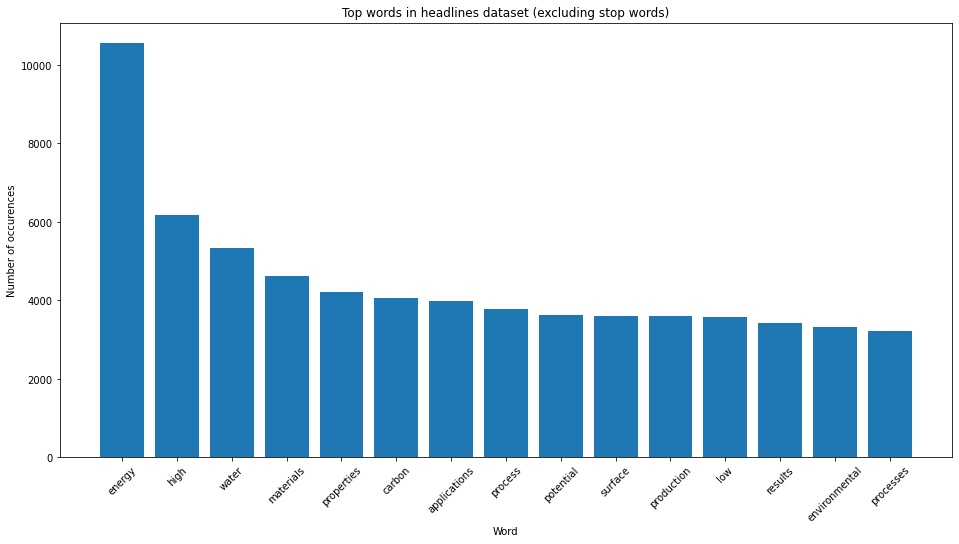

In [13]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation=45);
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [24]:
n_topics = 9
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=50000)
small_text_sample = reindexed_data.values
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

In [25]:
# LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [26]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [27]:
top_n_words_lda = get_top_n_words_topic_model(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  adsorption ph temperature concentration removal results rate process water order
Topic 2:  energy fuel emissions power gas carbon co2 reable hydrogen technologies
Topic 3:  mantle high crust rocks magma melting low arc melt subduction
Topic 4:  high energy thermal photocatalytic tio2 performance materials surface carbon heat
Topic 5:  energy materials applications properties process high methods production future performance
Topic 6:  water metal treatment removal soil organic adsorption metals surface biochar
Topic 7:  properties mechanical surface high strength slm composites membrane laser ti
Topic 8:  cells cell protein proteins effects stress biodiesel production acid role
Topic 9:  soil health environmental global effects change water climate urban energy


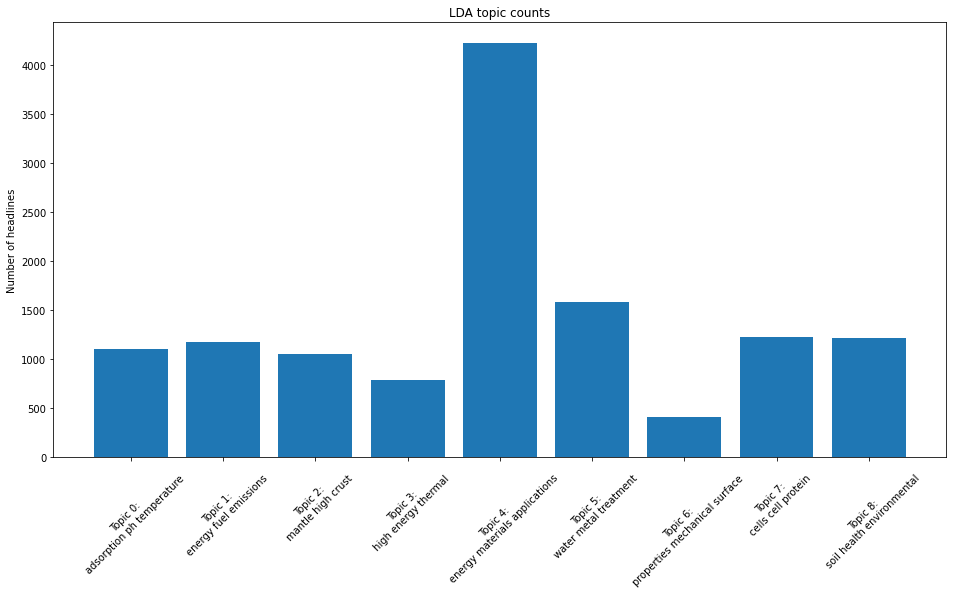

In [28]:
top_3_words = get_top_n_words_topic_model(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels,rotation = 45);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [19]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
docs_raw = selected_df.abstract
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


In [22]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=9, random_state=0)

In [23]:
panel = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)
pyLDAvis.display(panel)
pyLDAvis.save_html(panel,"mutil_lda_result.html")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [30]:
# Get Country Rank under each topic.
topic_words=[]
for topic in top_n_words_lda:
    topic_word = topic.split(" ")
    topic_words.append(topic_word)
print(len(topic_words))

threshold = 4
for topic in topic_words:
    country_dict  = defaultdict(int)
    for index in range(len(selected_df)):
        flag = 0
        words = selected_df.at[index,'abstract']
        country = selected_df.at[index,'affiliation-country']
        for top_word in topic:
            if top_word in words:
                flag +=1
            if flag>threshold:
                country_dict[country]+=1
                break
    # normalise the result on the ranking step.
    country_precent = defaultdict(float)
    for key,value in country_dict.items():
        country_precent[key] = round(value/country_num[key],4)
        pass
    country_precent = dict(sorted(country_precent.items(), key= lambda item: item[1],reverse=True))
    print("topic {} is-----".format(topic_words.index(topic)))
    
    print(country_precent.items())
    



9
topic 0 is-----
dict_items([('India', 0.3322), ('China', 0.1587), ('Australia', 0.1493), ('United States', 0.1078), ('New Zealand', 0.1031), ('United Kingdom', 0.0886)])
topic 1 is-----
dict_items([('India', 0.1104), ('United Kingdom', 0.0996), ('Australia', 0.0893), ('China', 0.0632), ('United States', 0.0589), ('New Zealand', 0.0206)])
topic 2 is-----
dict_items([('Australia', 0.0667), ('New Zealand', 0.0619), ('China', 0.0426), ('United States', 0.0392), ('United Kingdom', 0.0315), ('India', 0.0066)])
topic 3 is-----
dict_items([('China', 0.1157), ('India', 0.0971), ('New Zealand', 0.0928), ('Australia', 0.06), ('United Kingdom', 0.0505), ('United States', 0.0394)])
topic 4 is-----
dict_items([('New Zealand', 0.2371), ('China', 0.2086), ('Australia', 0.184), ('India', 0.1689), ('United Kingdom', 0.1384), ('United States', 0.1019)])
topic 5 is-----
dict_items([('India', 0.1236), ('China', 0.0675), ('Australia', 0.048), ('New Zealand', 0.0412), ('United States', 0.0282), ('United Ki